# **Automating News Content Coding with Large Language Models**

Author: Laura Vodden, Digital Media Research Centre, QUT

*September 19, 2024* | *Presented to Participants in the Helsinki Institute for Social Sciences and Humanities (HSSH)*



---



This Colab notebook guides users through some basic content coding tasks. We will use OpenAI's GPT via the API to code some news headlines, and then compare the results with some human coding that we have just done.

Specifically, we coded:
*   The stance of the text towards the COP26 summit
*   The primary emotion conveyed by the text

<br>

**To run a cell**, move your mouse over a cell, and click on the 'play' button that appears at the top left of the cell.

# **1. Setup**


---


**1.1 Download openai, plotly and agreement packages**

In [ ]:
! pip install openai
! pip install plotly
! pip install agreement


**1.2 Install dependencies**

This is a list of all the python packages that we will need to run this notebook

In [ ]:
import openai
from openai import OpenAI

import json
import pandas as pd
import os
import numpy as np

from agreement.utils.transform import pivot_table_frequency
from agreement.metrics import cohens_kappa, krippendorffs_alpha

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from google.colab import userdata


**1.3 Set your OpenAI API key and and configure OpenAI credentials**

We will set our OpenAI API key as a secret variable for security

1. Click on the key icon on the bar on the left
2. Click `+ Add new secret`
3. Click the toggle to allow Notebook access
4. Paste `openai_apikey` into 'Name' and your api key into 'Value'
5. Run the next cell

In [ ]:
# Get OpenAI API key

from google.colab import userdata

openai_apikey = userdata.get('openai_apikey')

client = OpenAI(api_key=openai_apikey)


:**1.4 Import article data**

This file contains the metadata relating to the articles that we have coded. We will load this file now, and come back to it later.

In [ ]:
# set url and read from google drive
url = 'https://docs.google.com/spreadsheets/d/1sUjcfGeIqyEnNzFhDxPpepSD_DB1KKotSq80b0SHfr0/edit?gid=309251339#gid=309251339'
html_data = pd.read_html(url)
article_df = pd.DataFrame(html_data[0])

# Set the first row as the header
article_df.columns = article_df.iloc[0]

# drop the first row
article_df = article_df[1:].reset_index(drop=True)
# drop the first column
article_df = article_df.iloc[:, 1:]

# drop columns where all NaN
article_df = article_df.dropna(axis=1, how='all')
# drop rows where all NaN
article_df = article_df.dropna(axis=0, how='all')

article_df.head()

,article_id,publication_title,title,full_text,full_text_truncated,publicaton_date
0,0,The Australian Financial Review,COP26 could be a turning point for carbon cred...,This week's climate change conference in Glasg...,This week's climate change conference in Glasg...,"Nov 1, 2021"
1,1,The Australian Financial Review,COP26 talks won't change Australia's carbon ch...,The decision by the world's richest G20 nation...,The decision by the world's richest G20 nation...,"Nov 1, 2021"
2,2,The Daily Telegraph,Privileged class showed their true priorities ...,Our reward for showing up to the COP26 UN Clim...,Our reward for showing up to the COP26 UN Clim...,"Nov 5, 2021"
3,3,EveningReport.nz,Take heart at what's unfolded at COP26 in Glas...,Source: The Conversation (Au and NZ) - By John...,Greta Thunberg has already pronounced the COP2...,"Nov 11, 2021"
4,4,Herald Sun,FIVE LIES THAT SHAME SUMMIT,I KNEW the Glasgow climate summit would be a f...,I knew the Glasgow climate summit would be a f...,"Nov 8, 2021"


**1.5 Import human-coded data**

This file contains the coded dataset that we have just created in our speed-coding round.

In [ ]:
# set url and read from google drive
url = 'https://docs.google.com/spreadsheets/d/15U-kb-ckHdUot7HFVYCfJtYA34x3Lf4Q1Zk83l5GKGI/edit?gid=206945254#gid=206945254'
html_data = pd.read_html(url)

# convert html_data to pd dataframe, with first column as header
df_human = pd.DataFrame(html_data[0])
# Set the first row as the header
df_human.columns = df_human.iloc[0]

# drop the first row
df_human = df_human[1:].reset_index(drop=True)
# drop the first column
df_human = df_human.iloc[:, 1:]

# convert all values to lower case
df_human = df_human.applymap(lambda x: x.lower() if isinstance(x, str) else x)

# drop rows and columns where all values are NaN
df_human = df_human.dropna(axis=0, how='all').dropna(axis=1, how='all')
df_human = df_human.fillna('none')

df_human.reset_index(drop=True, inplace=True)

print(f'Loaded dataframe with {len(df_human)} rows and {len(df_human.columns)} columns\n')

df_human.head()


Loaded dataframe with 16 rows and 21 columns



<ipython-input-11-8aa296e0b692>:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_human = df_human.applymap(lambda x: x.lower() if isinstance(x, str) else x)


,Timestamp,What do you think is the author's stance towards the COP26 event?,"Which primary emotion, if any, is conveyed by this text?",What do you think is the author's stance towards the COP26 event?,"Which primary emotion, if any, is conveyed by this text?",What do you think is the author's stance towards the COP26 event?,"Which primary emotion, if any, is conveyed by this text?",What do you think is the author's stance towards the COP26 event?,"Which primary emotion, if any, is conveyed by this text?",What do you think is the author's stance towards the COP26 event?,...,What do you think is the author's stance towards the COP26 event?,"Which primary emotion, if any, is conveyed by this text?",What do you think is the author's stance towards the COP26 event?,"Which primary emotion, if any, is conveyed by this text?",What do you think is the author's stance towards the COP26 event?,"Which primary emotion, if any, is conveyed by this text?",What do you think is the author's stance towards the COP26 event?,"Which primary emotion, if any, is conveyed by this text?",What do you think is the author's stance towards the COP26 event?,"Which primary emotion, if any, is conveyed by this headline?"
0,2024/09/18 4:38:21 am gmt+3,optimistic,hope,pessimistic,hopelessness,pessimistic,anger,neutral,hope,pessimistic,...,pessimistic,disappointment,pessimistic,hopelessness,pessimistic,hopelessness,optimistic,hope,pessimistic,disappointment
1,2024/09/18 7:34:48 am gmt+3,optimistic,hope,pessimistic,hopelessness,pessimistic,disappointment,neutral,none,pessimistic,...,pessimistic,disappointment,pessimistic,anger,pessimistic,anger,optimistic,hope,pessimistic,hopelessness
2,2024/09/19 1:36:51 pm gmt+3,optimistic,hope,pessimistic,disappointment,pessimistic,anger,pessimistic,hopelessness,pessimistic,...,neutral,none,pessimistic,disappointment,pessimistic,anger,neutral,none,pessimistic,disappointment
3,2024/09/19 1:38:16 pm gmt+3,optimistic,hope,pessimistic,disappointment,pessimistic,anger,neutral,hope,pessimistic,...,pessimistic,disappointment,pessimistic,hopelessness,pessimistic,disappointment,neutral,hope,pessimistic,disappointment
4,2024/09/19 1:38:53 pm gmt+3,optimistic,hope,pessimistic,disappointment,pessimistic,anger,neutral,none,pessimistic,...,neutral,none,neutral,none,pessimistic,none,optimistic,hope,pessimistic,none


# **2. Data cleaning**

The data we have loaded from Google Forms is not structured in a way that is useful to analyse, so we will need to process it further.

<br>

First, we will separate the responses to the questions into stance and emotion categories. This will allow us to deal with the two categories of coded data more easily.

---



**2.1 Extract separate dataframes for our stance and emotion data**



In [ ]:
# create stance df

df_stance_human = df_human.filter(regex='stance', axis=1)
df_stance_human.columns = ['article_' + str(i) for i in range(0, len(df_stance_human.columns))]

df_stance_human.head()


,article_0,article_1,article_2,article_3,article_4,article_5,article_6,article_7,article_8,article_9
0,optimistic,pessimistic,pessimistic,neutral,pessimistic,pessimistic,pessimistic,pessimistic,optimistic,pessimistic
1,optimistic,pessimistic,pessimistic,neutral,pessimistic,pessimistic,pessimistic,pessimistic,optimistic,pessimistic
2,optimistic,pessimistic,pessimistic,pessimistic,pessimistic,neutral,pessimistic,pessimistic,neutral,pessimistic
3,optimistic,pessimistic,pessimistic,neutral,pessimistic,pessimistic,pessimistic,pessimistic,neutral,pessimistic
4,optimistic,pessimistic,pessimistic,neutral,pessimistic,neutral,neutral,pessimistic,optimistic,pessimistic


In [ ]:
# create emotion df

df_emotion_human = df_human.filter(regex='emotion', axis=1)
df_emotion_human.columns = ['article_' + str(i) for i in range(0, len(df_emotion_human.columns))]

df_emotion_human.head()


,article_0,article_1,article_2,article_3,article_4,article_5,article_6,article_7,article_8,article_9
0,hope,hopelessness,anger,hope,anger,disappointment,hopelessness,hopelessness,hope,disappointment
1,hope,hopelessness,disappointment,none,anger,disappointment,anger,anger,hope,hopelessness
2,hope,disappointment,anger,hopelessness,anger,none,disappointment,anger,none,disappointment
3,hope,disappointment,anger,hope,anger,disappointment,hopelessness,disappointment,hope,disappointment
4,hope,disappointment,anger,none,anger,none,none,none,hope,none


**2.2 Prepare dataframes for agreement calculation**

In [ ]:
# define a function to manipulate the dataframes so that we can use them in the agreement calculations

def transform_human_data(df, value_name):
    # transpose the dataframe
    df_transpose = df.T
    # rename index to article_id
    df_transpose.index.name = 'article_id'
    # Reset index
    df_transpose = df_transpose.reset_index()
    # melt DataFrame to represent coder (columns) vertically
    df_transpose = df_transpose.melt(id_vars=['article_id'], var_name='rater_id', value_name=value_name)
    # add rater_type column
    df_transpose['rater_type'] = 'human'
    # remove 'article_' prefix from article_id values
    df_transpose['article_id'] = df_transpose['article_id'].str.replace('article_', '')
    # convert columns to appropriate data types
    df_transpose['article_id'] = pd.to_numeric(df_transpose['article_id'], errors='coerce')
    df_transpose['rater_id'] = pd.to_numeric(df_transpose['rater_id'], errors='coerce')
    df_transpose[value_name] = df_transpose[value_name].astype(str)
    df_transpose['rater_type'] = df_transpose['rater_type'].astype(str)

    return df_transpose


In [ ]:
# apply the function to both dataframes
df_emotion_human_transpose = transform_human_data(df_emotion_human, 'emotion')
df_stance_human_transpose = transform_human_data(df_stance_human, 'stance')

# view stance_human_transpose dataframe (first 5 rows)
df_stance_human_transpose


,article_id,rater_id,stance,rater_type
0,0,0,optimistic,human
1,1,0,pessimistic,human
2,2,0,pessimistic,human
3,3,0,neutral,human
4,4,0,pessimistic,human
...,...,...,...,...
155,5,15,neutral,human
156,6,15,pessimistic,human
157,7,15,pessimistic,human
158,8,15,optimistic,human


In [ ]:
# view emotion_human_transpose dataframe
df_emotion_human_transpose.head()

,article_id,rater_id,emotion,rater_type
0,0,0,hope,human
1,1,0,hopelessness,human
2,2,0,anger,human
3,3,0,hope,human
4,4,0,anger,human


# **3. Calculate agreement between human coders for stance and emotion**

Now that our human-coded data for stance and emotions are correctly structured, we can have a look at our inter-coder agreement.

<br>

We will use the `agreement` python package: https://pypi.org/project/agreement/ to calculate the Krippendorff's Alpha coefficient, and assess the reliability of our coding.

<br>

Read more here: https://www.asc.upenn.edu/sites/default/files/2021-03/Computing%20Krippendorff%27s%20Alpha-Reliability.pdf

---

**3.1 Calculate Krippendorff's Alpha for stance and emotion codes**

In [ ]:
# Define a function to process the DataFrame and calculate Krippendorff's alpha
def calculate_alpha(df_transpose, value_col_index, cat):
    # Convert DataFrame to numpy array
    human_transpose = df_transpose.to_numpy()

    # Generate frequency tables for questions and users
    questions_answers_table = pivot_table_frequency(human_transpose[:, 0], human_transpose[:, value_col_index])
    users_answers_table = pivot_table_frequency(human_transpose[:, 1], human_transpose[:, value_col_index])

    # Calculate Krippendorff's alpha
    alpha = krippendorffs_alpha(questions_answers_table)

    # Print the alpha value
    print(f"Alpha ({cat}): {alpha}")

    return alpha

# Assuming the value column index is 2 for both stance and emotion (based on your provided code)
stance_alpha = calculate_alpha(df_stance_human_transpose, 2, cat='stance')
emotion_alpha = calculate_alpha(df_emotion_human_transpose, 2, cat='emotion')

Alpha (stance): 0.5344326187977815
Alpha (emotion): 0.3654031287605292


# **4. Visualise agreement percentage between humans**

To help us interpret these coefficients, it helps to visualise how each article has been coded. Let's explore two visualisations:

**4.1 Bar plot: Percentage of Raters for Each Stance/Emotion per Article**

* These plots provide a visual summary of how articles are perceived in terms of stance and emotion by different raters.
* They help identify articles where there is strong agreement among raters and those where opinions are more divided.
* They can also highlight patterns, such as if certain articles consistently evoke a particular stance or emotion among the raters.

In [ ]:
# Function to process data and return a pivot table for plotting
def process_data(df, value_column):
    # Count the number of raters for each category per article
    counts = df.groupby(['article_id', value_column])['rater_id'].count().reset_index(name='count')

    # Calculate the total number of raters per article
    total_raters = df.groupby('article_id')['rater_id'].count().reset_index(name='total_raters')

    # Merge counts with total raters to compute percentage of raters for each category
    processed_data = counts.merge(total_raters, on='article_id')
    processed_data['percentage'] = (processed_data['count'] / processed_data['total_raters']) * 100

    return processed_data

# Convert data to DataFrames with appropriate columns
df_stance_human_transpose = pd.DataFrame(df_stance_human_transpose, columns=['article_id', 'rater_id', 'rater_type', 'stance'])
df_emotion_human_transpose = pd.DataFrame(df_emotion_human_transpose, columns=['article_id', 'rater_id', 'rater_type', 'emotion'])

# Assume you have a separate DataFrame called article_data with columns ['article_id', 'title']
article_headlines = article_df[['article_id', 'title']]
# Ensure article_id is of int type
article_headlines['article_id'] = article_headlines['article_id'].astype(int)

# Merge article headlines into your data
df_stance_human_transpose = df_stance_human_transpose.merge(article_headlines, on='article_id', how='left')
df_emotion_human_transpose = df_emotion_human_transpose.merge(article_headlines, on='article_id', how='left')

# Process stance and emotion data
stance_data = process_data(df_stance_human_transpose, 'stance')
emotion_data = process_data(df_emotion_human_transpose, 'emotion')

<ipython-input-18-d895f478920e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_headlines['article_id'] = article_headlines['article_id'].astype(int)


In [ ]:
# Convert data to DataFrames with appropriate columns
df_stance_human_transpose = pd.DataFrame(df_stance_human_transpose, columns=['article_id', 'rater_id', 'rater_type', 'stance'])
df_emotion_human_transpose = pd.DataFrame(df_emotion_human_transpose, columns=['article_id', 'rater_id', 'rater_type', 'emotion'])

# Assume you have a separate DataFrame called article_data with columns ['article_id', 'title']
article_headlines = article_df[['article_id', 'title']]
# Ensure article_id is of int type
article_headlines['article_id'] = article_headlines['article_id'].astype(int)

# Merge article headlines into your data
df_stance_human_transpose = df_stance_human_transpose.merge(article_headlines, on='article_id', how='left')
df_emotion_human_transpose = df_emotion_human_transpose.merge(article_headlines, on='article_id', how='left')

# Process stance and emotion data
stance_data = process_data(df_stance_human_transpose, 'stance')
emotion_data = process_data(df_emotion_human_transpose, 'emotion')

fig_stance = go.Figure()

# Add stance traces (categories like optimistic, pessimistic, etc.)
for stance_category in df_stance_human_transpose['stance'].unique():
    stance_subset = stance_data[stance_data['stance'] == stance_category]

    # Use the 'title' column for hovertext, adding stance category
    merged_data = stance_subset.merge(article_headlines, on='article_id', how='left')

    fig_stance.add_trace(go.Bar(
        x=stance_subset['article_id'],
        y=stance_subset['percentage'],
        name=stance_category,
        hovertext=[f"Article ID: {row['article_id']}<br>Headline: {row['title']}<br>Stance: {stance_category}" for _, row in merged_data.iterrows()],
        hoverinfo="text"
    ))

# Update layout for stance plot
fig_stance.update_layout(
    title="Percentage of Coders for Each Stance per Article",
    barmode='stack',
    xaxis_title="Article ID",
    yaxis_title="Percentage of Coders (%)",
    legend_title="Stance",
    xaxis_tickmode='linear',
    width=800,  # Adjust the width
    height=400  # Adjust the height
)

# --- Create interactive stacked bar chart for emotion ---
fig_emotion = go.Figure()

# Add emotion traces (categories like happy, sad, etc.)
for emotion_category in df_emotion_human_transpose['emotion'].unique():
    emotion_subset = emotion_data[emotion_data['emotion'] == emotion_category]

    # Use the 'title' column for hovertext, adding emotion category
    merged_data = emotion_subset.merge(article_headlines, on='article_id', how='left')

    fig_emotion.add_trace(go.Bar(
        x=emotion_subset['article_id'],
        y=emotion_subset['percentage'],
        name=emotion_category,
        hovertext=[f"Article ID: {row['article_id']}<br>Headline: {row['title']}<br>Emotion: {emotion_category}" for _, row in merged_data.iterrows()],
        hoverinfo="text"
    ))

# Update layout for emotion plot
fig_emotion.update_layout(
    title="Percentage of Coders for Each Emotion per Article",
    barmode='stack',
    xaxis_title="Article ID",
    yaxis_title="Percentage of Coders (%)",
    legend_title="Emotion",
    xaxis_tickmode='linear',
    width=800,  # Adjust the width
    height=400  # Adjust the height
)

# Show both plots
fig_stance.show()
fig_emotion.show()

<ipython-input-19-24471dfddbf7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_headlines['article_id'] = article_headlines['article_id'].astype(int)


**4.2 Agreement Heat Map: Visual comparison of pairwise agreement percentages between raters for stance and emotion annotations**

By analyzing these heatmaps, you can assess how consistently different raters align in their evaluations of stance and emotion, thereby evaluating the reliability and consistency of the annotation process. THese heat maps also make it possible to identify coders with high rates of disagreement and investigate the causes.

<ipython-input-20-f0efa39f31c7>:57: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



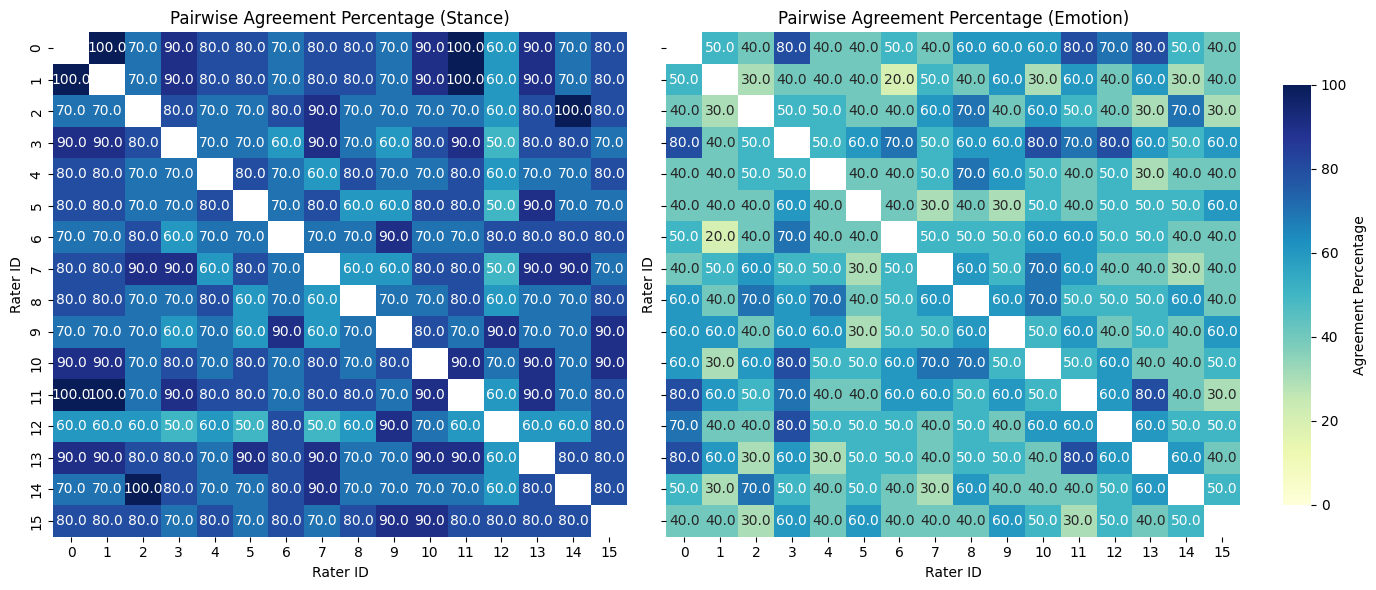

In [ ]:
# Ensure DataFrames are properly set up
stance_human_transpose = pd.DataFrame(df_stance_human_transpose, columns=['article_id', 'rater_id', 'rater_type', 'stance'])
emotion_human_transpose = pd.DataFrame(df_emotion_human_transpose, columns=['article_id', 'rater_id', 'rater_type', 'emotion'])

# Helper function to calculate agreement matrix
def calculate_agreement_matrix(df, value_column):
    # Pivot the DataFrame to create a matrix of articles by raters with values as the pivoted column
    pivot_df = df.pivot(index='article_id', columns='rater_id', values=value_column)

    # Calculate pairwise agreement between each pair of raters
    rater_ids = pivot_df.columns
    agreement_matrix = np.zeros((len(rater_ids), len(rater_ids)))

    # Function to calculate agreement percentage between two raters
    def calculate_agreement(rater1, rater2):
        agreement = (pivot_df[rater1] == pivot_df[rater2])  # True where values match
        return agreement.mean() * 100  # Convert to percentage

    # Fill the agreement matrix
    for i, rater1 in enumerate(rater_ids):
        for j, rater2 in enumerate(rater_ids):
            if i != j:
                agreement_matrix[i, j] = calculate_agreement(rater1, rater2)
            else:
                agreement_matrix[i, j] = np.nan  # Optionally use NaN to ignore self-agreement

    return agreement_matrix, rater_ids

# Calculate agreement matrices for stance and emotion data
agreement_matrix_stance, rater_ids_stance = calculate_agreement_matrix(stance_human_transpose, 'stance')
agreement_matrix_emotion, rater_ids_emotion = calculate_agreement_matrix(emotion_human_transpose, 'emotion')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Define a shared colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust to position the colorbar between the subplots

# Plot heat map for stance data
sns.heatmap(agreement_matrix_stance, annot=True, fmt=".1f", cmap="YlGnBu",
            xticklabels=rater_ids_stance, yticklabels=rater_ids_stance,
            vmin=0, vmax=100,  # Set limits for the color scale
            cbar_ax=cbar_ax, cbar_kws={'label': 'Agreement Percentage'}, ax=axes[0])
axes[0].set_title('Pairwise Agreement Percentage (Stance)')
axes[0].set_xlabel('Rater ID')
axes[0].set_ylabel('Rater ID')

# Plot heat map for emotion data
sns.heatmap(agreement_matrix_emotion, annot=True, fmt=".1f", cmap="YlGnBu",
            xticklabels=rater_ids_emotion, yticklabels=rater_ids_emotion,
            vmin=0, vmax=100,  # Set limits for the color scale
            cbar=False, ax=axes[1])  # Disable the second colorbar
axes[1].set_title('Pairwise Agreement Percentage (Emotion)')
axes[1].set_xlabel('Rater ID')
axes[1].set_ylabel('Rater ID')  # Explicitly set the ylabel to ensure visibility

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate the shared colorbar
plt.show()

# **5. Let's see how well the LLM performs the same task**

Let's refresh our memory about the first file we loaded, which contains the article data for the 10 articles we coded. Remember, we manually coded the headline and a small portion of text. These are located in the `title` and `full_text_truncated` columns. We can open the inveractive table (the table icon at the top right of the table) to explore and verify.

---




In [ ]:
article_df

,article_id,publication_title,title,full_text,full_text_truncated,publicaton_date
0,0,The Australian Financial Review,COP26 could be a turning point for carbon cred...,This week's climate change conference in Glasg...,This week's climate change conference in Glasg...,"Nov 1, 2021"
1,1,The Australian Financial Review,COP26 talks won't change Australia's carbon ch...,The decision by the world's richest G20 nation...,The decision by the world's richest G20 nation...,"Nov 1, 2021"
2,2,The Daily Telegraph,Privileged class showed their true priorities ...,Our reward for showing up to the COP26 UN Clim...,Our reward for showing up to the COP26 UN Clim...,"Nov 5, 2021"
3,3,EveningReport.nz,Take heart at what's unfolded at COP26 in Glas...,Source: The Conversation (Au and NZ) - By John...,Greta Thunberg has already pronounced the COP2...,"Nov 11, 2021"
4,4,Herald Sun,FIVE LIES THAT SHAME SUMMIT,I KNEW the Glasgow climate summit would be a f...,I knew the Glasgow climate summit would be a f...,"Nov 8, 2021"
5,5,Sydney Morning Herald,Hopes unfulfilled: G20 fails to agree over cli...,Rome: Hopes that leaders of the world's larges...,Hopes that leaders of the world's largest econ...,"Nov 2, 2021"
6,6,The Australian,COP26 summit: Hot air dissipates to reveal the...,Tough negotiations are still ahead on finance ...,Tough negotiations are still ahead on finance ...,"Nov 2, 2021"
7,7,The Australian,A green jamboree joined at core by self-interest,"As COP26 enters its second week, it has become...","As COP26 enters its second week, it has become...","Nov 8, 2021"
8,8,The Canberra Times,"Carbon pollution on the rise, but COP26 pledge...",Global carbon emissions are set to surge back ...,Global carbon emissions are set to surge back ...,"Nov 5, 2021"
9,9,The Daily Advertiser,Failure of G20 bodes ill for COP26 conference,"Ray's reasoning As I write this, the COP26 cli...","As I write this, the COP26 climate conference ...","Nov 9, 2021"


**5.1 Prepare input for llm**

This function serves as a 'prompt builder'. We define it first, and then later we will pass each article text into this function.

In [ ]:
# Define a function to generate input, incorporating the article text in each run

def generate_input(article_text):
  input = f'''

  Please read the following text and answer the following questions:
    1. What do you think is the author's stance towards the COP26 event?
    2. Which primary emotion, if any, is conveyed by this text?

    Don't overthink! Select the first answer that comes to mind.
    If there is more than one emotion present in the text, choose the strongest one.

  ```{article_text}```

  Return your response as a valid json as per the following template:

   "analysis": [
                "stance": <String: The author's stance towards the COP26 event: Choose from optimistic, pessimistic, neutral>,
                "emotion": <String: The primary emotion conveyed by the text: Choose from joy, hope, hopelessness, disappointment, anger or none>,
                ]
  ```
  '''
  return input

**5.2 Create the combined text field that we want to pass to the LLM**

Here we combine the `title` and `full_text_truncated` column and create a new column called `headline_and_trunc`.

In [ ]:
# combine headline and full_text_truncated data
article_df['headline_and_trunc'] = article_df['title'] + ' ' + article_df['full_text_truncated']
article_df

,article_id,publication_title,title,full_text,full_text_truncated,publicaton_date,headline_and_trunc
0,0,The Australian Financial Review,COP26 could be a turning point for carbon cred...,This week's climate change conference in Glasg...,This week's climate change conference in Glasg...,"Nov 1, 2021",COP26 could be a turning point for carbon cred...
1,1,The Australian Financial Review,COP26 talks won't change Australia's carbon ch...,The decision by the world's richest G20 nation...,The decision by the world's richest G20 nation...,"Nov 1, 2021",COP26 talks won't change Australia's carbon ch...
2,2,The Daily Telegraph,Privileged class showed their true priorities ...,Our reward for showing up to the COP26 UN Clim...,Our reward for showing up to the COP26 UN Clim...,"Nov 5, 2021",Privileged class showed their true priorities ...
3,3,EveningReport.nz,Take heart at what's unfolded at COP26 in Glas...,Source: The Conversation (Au and NZ) - By John...,Greta Thunberg has already pronounced the COP2...,"Nov 11, 2021",Take heart at what's unfolded at COP26 in Glas...
4,4,Herald Sun,FIVE LIES THAT SHAME SUMMIT,I KNEW the Glasgow climate summit would be a f...,I knew the Glasgow climate summit would be a f...,"Nov 8, 2021",FIVE LIES THAT SHAME SUMMIT I knew the Glasgow...
5,5,Sydney Morning Herald,Hopes unfulfilled: G20 fails to agree over cli...,Rome: Hopes that leaders of the world's larges...,Hopes that leaders of the world's largest econ...,"Nov 2, 2021",Hopes unfulfilled: G20 fails to agree over cli...
6,6,The Australian,COP26 summit: Hot air dissipates to reveal the...,Tough negotiations are still ahead on finance ...,Tough negotiations are still ahead on finance ...,"Nov 2, 2021",COP26 summit: Hot air dissipates to reveal the...
7,7,The Australian,A green jamboree joined at core by self-interest,"As COP26 enters its second week, it has become...","As COP26 enters its second week, it has become...","Nov 8, 2021",A green jamboree joined at core by self-intere...
8,8,The Canberra Times,"Carbon pollution on the rise, but COP26 pledge...",Global carbon emissions are set to surge back ...,Global carbon emissions are set to surge back ...,"Nov 5, 2021","Carbon pollution on the rise, but COP26 pledge..."
9,9,The Daily Advertiser,Failure of G20 bodes ill for COP26 conference,"Ray's reasoning As I write this, the COP26 cli...","As I write this, the COP26 climate conference ...","Nov 9, 2021",Failure of G20 bodes ill for COP26 conference ...


**5.3 Ask LLM to analyse each article 5 times**

This should take about a minute or less.

In [ ]:
MODEL = 'gpt-4o'

results = []

# iterate through each row in article_data
for i in range(len(article_df)):

    # set new headline_and_trunc column as article text
    article_text = article_df['headline_and_trunc'][i]
    article_id = article_df['article_id'][i]

    # pass article_text to generate_input function
    input = generate_input(article_text)
    rater_id = len(df_human) - 1

    # Repeat the analysis 5 times for each article
    for _ in range(5):
        rater_id = rater_id + 1
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": "You are a helpful assistant that helps me analyse the stance and emotion in the text of news articles!"},
                {"role": "user", "content": f"{input}"}
            ]
        )

        g = completion.choices[0].message.content
        print(g)

        # Add each result to the list with the article_id and the response
        j = {"article_id": article_id, "title": article_text, "rater_id": rater_id, "data": g}
        results.append(j)


```json
{
  "analysis": [
    {
      "stance": "optimistic",
      "emotion": "hope"
    }
  ]
}
```
```json
{
   "analysis": [
      {
         "stance": "optimistic",
         "emotion": "hope"
      }
   ]
}
```
```json
{
  "analysis": {
    "stance": "optimistic",
    "emotion": "hope"
  }
}
```
```json
{
  "analysis": [
    {
      "stance": "optimistic",
      "emotion": "hope"
    }
  ]
}
```
```json
{
  "analysis": [
    {
      "stance": "optimistic",
      "emotion": "hope"
    }
  ]
}
```
```json
{
  "analysis": [
    {
      "stance": "pessimistic",
      "emotion": "disappointment"
    }
  ]
}
```
```json
{
  "analysis": [
    {
      "stance": "pessimistic",
      "emotion": "disappointment"
    }
  ]
}
```
```json
{
  "analysis": [
    {
      "stance": "pessimistic",
      "emotion": "disappointment"
    }
  ]
}
```
```json
{
  "analysis": [
    {
      "stance": "pessimistic",
      "emotion": "disappointment"
    }
  ]
}
```
```json
{
  "analysis": [
    {
      "sta

**5.3 Process results and show dataframe**

The data that come out of the LLM need to be processed a little, from a nested JSON to a dataframe.

In [ ]:
# Initialize list to store extracted data
parsed_data = []

for item in results:
    # Clean the 'data' field by removing the JSON markers
    json_str = item['data'].strip('```json\n').strip('\n```')
    json_str = item['data'].strip(' ```json\n').strip('\n ```')
    # Parse the cleaned JSON string
    try:
        parsed_json = json.loads(json_str)
        # Normalize 'analysis' to a list if it's a dictionary
        if isinstance(parsed_json['analysis'], dict):
            parsed_json['analysis'] = [parsed_json['analysis']]
        # Append each entry with 'article_id' and select relevant fields
        for entry in parsed_json['analysis']:
            parsed_data.append({
                'article_id': item['article_id'],
                'rater_id': item['rater_id'],
                'stance': entry.get('stance'),
                'emotion': entry.get('emotion'),
                'title': item['title']
            })

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON for article_id {item['article_id']}: {e}")

# Create DataFrame
df_AI= pd.DataFrame(parsed_data, columns=['article_id', 'rater_id', 'stance', 'emotion', 'title'])
df_AI['rater_type'] = 'AI'

df_AI.head(10)

,article_id,rater_id,stance,emotion,title,rater_type
0,0,16,optimistic,hope,COP26 could be a turning point for carbon cred...,AI
1,0,17,optimistic,hope,COP26 could be a turning point for carbon cred...,AI
2,0,18,optimistic,hope,COP26 could be a turning point for carbon cred...,AI
3,0,19,optimistic,hope,COP26 could be a turning point for carbon cred...,AI
4,0,20,optimistic,hope,COP26 could be a turning point for carbon cred...,AI
5,1,16,pessimistic,disappointment,COP26 talks won't change Australia's carbon ch...,AI
6,1,17,pessimistic,disappointment,COP26 talks won't change Australia's carbon ch...,AI
7,1,18,pessimistic,disappointment,COP26 talks won't change Australia's carbon ch...,AI
8,1,19,pessimistic,disappointment,COP26 talks won't change Australia's carbon ch...,AI
9,1,20,pessimistic,disappointment,COP26 talks won't change Australia's carbon ch...,AI


**5.4 Separate into stance and emotion dataframes**

This will allow us to eventually join the human and AI coded data.

In [ ]:
# append AI stance data to human stance data
df_stance_AI = df_AI[['article_id', 'rater_id', 'rater_type', 'stance', 'title']]
df_emotion_AI = df_AI[['article_id', 'rater_id', 'rater_type', 'emotion', 'title']]


**5.5 Append AI stance and emotion data to human dataframes**

This will combine the human and AI coded data so that we can measure agreement between human and AI coders.

In [ ]:
stance_data = pd.concat([df_stance_human_transpose, df_stance_AI]).reset_index(drop=True)
emotion_data = pd.concat([df_emotion_human_transpose, df_emotion_AI]).reset_index(drop=True)

# Specify the desired data types in a dictionary format
stance_data_types = {
    'article_id': 'int',
    'rater_id': 'int',
    'rater_type': 'category',
    'stance': 'category',
    'title': 'str'
}

emotion_data_types = {
    'article_id': 'int',
    'rater_id': 'int',
    'rater_type': 'category',
    'emotion': 'category',
    'title': 'str'
}

# Apply the data types to the DataFrames
stance_data = stance_data.astype(stance_data_types)
emotion_data = emotion_data.astype(emotion_data_types)

stance_data

,article_id,rater_id,rater_type,stance,title
0,0,0,human,optimistic,COP26 could be a turning point for carbon cred...
1,1,0,human,pessimistic,COP26 talks won't change Australia's carbon ch...
2,2,0,human,pessimistic,Privileged class showed their true priorities ...
3,3,0,human,neutral,Take heart at what's unfolded at COP26 in Glas...
4,4,0,human,pessimistic,FIVE LIES THAT SHAME SUMMIT
...,...,...,...,...,...
205,9,16,AI,pessimistic,Failure of G20 bodes ill for COP26 conference ...
206,9,17,AI,pessimistic,Failure of G20 bodes ill for COP26 conference ...
207,9,18,AI,pessimistic,Failure of G20 bodes ill for COP26 conference ...
208,9,19,AI,pessimistic,Failure of G20 bodes ill for COP26 conference ...


# **6. Calculate Inter-coder Agreement Between Humans and LLMs**

**6.1 Calculate Krippendorff's Alpha**

In [ ]:
# Assuming the value column index is 2 for both stance and emotion (based on your provided code)
stance_alpha = calculate_alpha(stance_data[['article_id', 'rater_id', 'stance']], 2, cat='stance')
emotion_alpha = calculate_alpha(emotion_data[['article_id', 'rater_id', 'emotion']], 2, cat='emotion')

Alpha (stance): 0.5808022922636104
Alpha (emotion): 0.4000633866586174


**6.2 Bar chart**

This will look different for everyone!



In [ ]:
pivot_table_stance = process_data(stance_data, 'stance')
pivot_table_emotion = process_data(emotion_data, 'emotion')

# --- Create interactive stacked bar chart for stance ---
fig_stance = go.Figure()

# Add stance traces (categories like optimistic, pessimistic, etc.)
for stance_category in df_stance_human_transpose['stance'].unique():
    stance_subset = pivot_table_stance[pivot_table_stance['stance'] == stance_category]

    # Use the 'title' column for hovertext, adding stance category
    merged_data = stance_subset.merge(article_headlines, on='article_id', how='left')

    fig_stance.add_trace(go.Bar(
        x=stance_subset['article_id'],
        y=stance_subset['percentage'],
        name=stance_category,
        hovertext=[f"Article ID: {row['article_id']}<br>Headline: {row['title']}<br>Stance: {stance_category}" for _, row in merged_data.iterrows()],
        hoverinfo="text"
    ))

# Update layout for stance plot with reduced size (80%)
fig_stance.update_layout(
    title="Percentage of Raters for Each Stance per Article",
    barmode='stack',
    xaxis_title="Article ID",
    yaxis_title="Percentage of Raters (%)",
    legend_title="Stance",
    xaxis_tickmode='linear',
    width=800,  # 80% of the typical default width
    height=500  # 80% of the typical default height
)

# --- Create interactive stacked bar chart for emotion ---
fig_emotion = go.Figure()

# Add emotion traces (categories like happy, sad, etc.)
for emotion_category in df_emotion_human_transpose['emotion'].unique():
    emotion_subset = pivot_table_emotion[pivot_table_emotion['emotion'] == emotion_category]

    # Use the 'title' column for hovertext, adding emotion category
    merged_data = emotion_subset.merge(article_headlines, on='article_id', how='left')

    fig_emotion.add_trace(go.Bar(
        x=emotion_subset['article_id'],
        y=emotion_subset['percentage'],
        name=emotion_category,
        hovertext=[f"Article ID: {row['article_id']}<br>Headline: {row['title']}<br>Emotion: {emotion_category}" for _, row in merged_data.iterrows()],
        hoverinfo="text"
    ))

# Update layout for emotion plot with reduced size (80%)
fig_emotion.update_layout(
    title="Percentage of Raters for Each Emotion per Article",
    barmode='stack',
    xaxis_title="Article ID",
    yaxis_title="Percentage of Raters (%)",
    legend_title="Emotion",
    xaxis_tickmode='linear',
    width=800,  # 80% of the typical default width
    height=500  # 80% of the typical default height
)

# Show both plots
fig_stance.show()
fig_emotion.show()

<ipython-input-18-d895f478920e>:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-18-d895f478920e>:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



**6.3 Visualise pairwise agreement percentages between raters for stance and emotion.**

Pairwise agreement refers to the level of agreement between two raters or evaluators when assessing the same set of items. It measures how consistently two individuals rate or categorize the same items.

How Pairwise Agreement is Calculated:
Comparison:

```
# This is formatted as code
```



For each pair of raters, compare their evaluations for each article.
Determine if their evaluations agree or disagree.
Agreement Calculation:

Agreement: Count the number of times both raters provide the same evaluation for the same article.

Total Evaluations: Count the total number of evaluations both raters made for the same articles.

Percentage: Calculate the percentage of times the evaluations agree using the formula:

Agreement Percentage
=
(
Number of Agreements
Total Evaluations
)
×
100
Agreement Percentage=(
Total Evaluations
Number of Agreements
​
 )×100

<ipython-input-32-87bb8db9fba9>:29: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



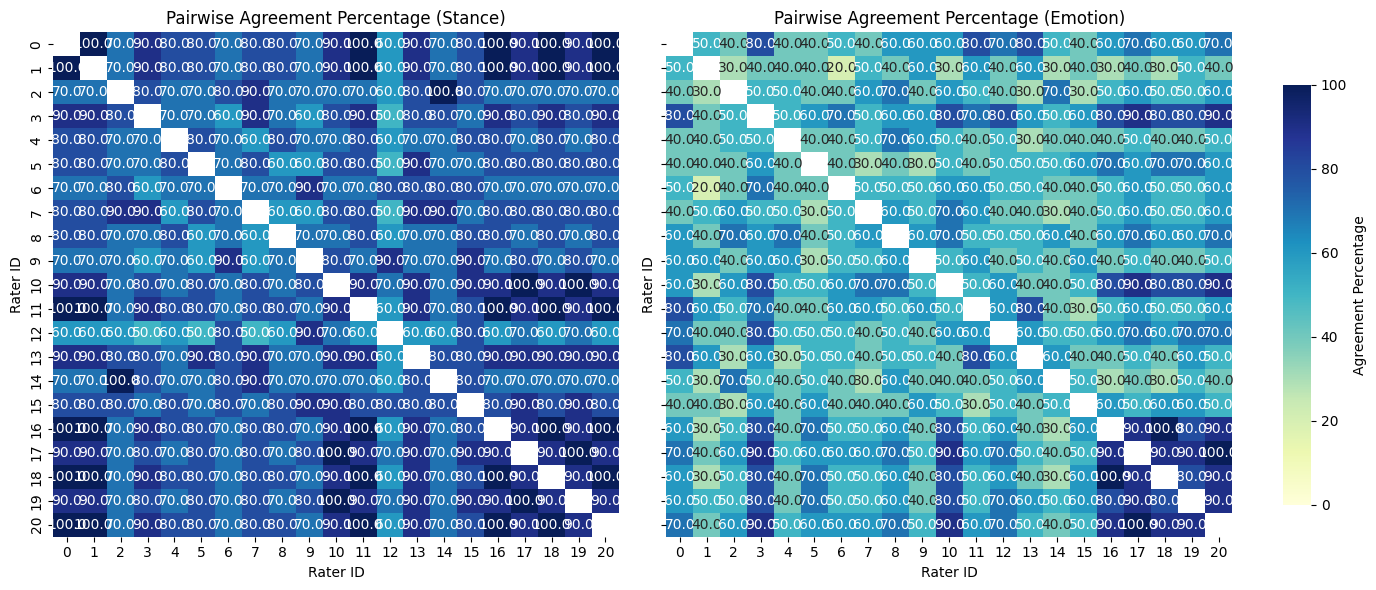

In [ ]:

# Calculate agreement matrices for stance and emotion data
agreement_matrix_stance, rater_ids_stance = calculate_agreement_matrix(stance_data, 'stance')
agreement_matrix_emotion, rater_ids_emotion = calculate_agreement_matrix(emotion_data, 'emotion')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Define a shared colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust to position the colorbar between the subplots

# Plot heat map for stance data
sns.heatmap(agreement_matrix_stance, annot=True, fmt=".1f", cmap="YlGnBu",
            xticklabels=rater_ids_stance, yticklabels=rater_ids_stance,
            vmin=0, vmax=100,  # Set limits for the color scale
            cbar_ax=cbar_ax, cbar_kws={'label': 'Agreement Percentage'}, ax=axes[0])
axes[0].set_title('Pairwise Agreement Percentage (Stance)')
axes[0].set_xlabel('Rater ID')
axes[0].set_ylabel('Rater ID')

# Plot heat map for emotion data
sns.heatmap(agreement_matrix_emotion, annot=True, fmt=".1f", cmap="YlGnBu",
            xticklabels=rater_ids_emotion, yticklabels=rater_ids_emotion,
            vmin=0, vmax=100,  # Set limits for the color scale
            cbar=False, ax=axes[1])  # Disable the second colorbar
axes[1].set_title('Pairwise Agreement Percentage (Emotion)')
axes[1].set_xlabel('Rater ID')
axes[1].set_ylabel('Rater ID')  # Explicitly set the ylabel to ensure visibility

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate the shared colorbar
plt.show()

# **7. Evaluating Reliabiliy of LLM predictions**

Our last step is to calculate some statistics that will help us to understand whether the LLM has performed well.


# **7. Evaluating Reliabiliy of LLM predictions**:

**Calculate Precision, Recall, Accuracy and F1**



---

<br>

**Precision** is the measure of the correctly identified positive cases from all the predicted positive cases.

It can be calculated using the formula:

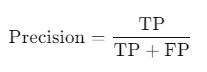

<br>

**Recall** is the measure of the correctly identified positive cases from all the actual positive cases.

It can be calculated using the formula:

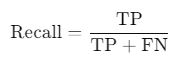

<br>

**Accuracy** is the measure of all the correctly identified cases.

It can be calculated using the formula:

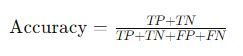

<br>

**F1** is the harmonic mean of **Precision** and **Recall**.

It can be calculated using the formula:

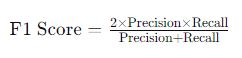


Read more [here](https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2).

<br>

**8.1 Use the most common responses for stance and emotion for each article as our 'ground truth'**


For the purpose of this exercise, we will take the most common answer for each question from the human and AI coders. At this point, we assuming here that our human coded data are correct, but in reality we probably would have to do some more work to verify that this is true. But from now on, we will treat this as our **gold standard**.

<br>

Continuing with this assumption, we want to compare the LLM codes with our gold standard human codes.

<br>

The next cell creates our gold standard

In [ ]:
from re import M

# get ground truth (godl standard) and predictions
def get_most_common_answer(data, column, rater_type):
    filt_data = data[data['rater_type'] == rater_type].groupby('article_id')[column].apply(lambda x: x.value_counts().idxmax())

    filt_array = np.array(filt_data)
    return filt_data, filt_array


def create_stance_emot_df(cat_series, label, cat):
    # Extract unique stances from the Series
    unique_cats = cat_series.unique()

    # Initialize a list to store the rows for the new DataFrame
    data = []

    # Loop over each article_id in the index of the Series
    for article_id in cat_series.index:
        # Get the correct stance from the Series
        correct_cat = cat_series.loc[article_id]

        # For each stance, check if it matches the correct stance
        for category in unique_cats:
            is_correct = category == correct_cat
            data.append({'article_id': article_id, cat: category, label: is_correct})

    # Create the new DataFrame
    return pd.DataFrame(data)


# Get the most common answer for each article by rater type and column
ground_truth_stance_human, ground_truth_stance_human_array = get_most_common_answer(stance_data, 'stance', 'human')
preds_stance_AI, preds_stance_AI_array = get_most_common_answer(stance_data, 'stance', 'AI')
ground_truth_emotion_human, ground_truth_emotion_human_array = get_most_common_answer(emotion_data, 'emotion', 'human')
preds_emotion_AI, preds_emotion_AI_array = get_most_common_answer(emotion_data, 'emotion', 'AI')


# Create the DataFrames
stance_assignments_human = create_stance_emot_df(ground_truth_stance_human, 'assigned', cat='stance')
stance_preds_AI = create_stance_emot_df(preds_stance_AI, 'pred', cat='stance')
emotion_assignments_human = create_stance_emot_df(ground_truth_emotion_human, 'assigned',  cat='emotion')
emotion_preds_AI = create_stance_emot_df(preds_emotion_AI, 'pred', cat='emotion')

**8.2 Restructure our data for comparison**

In [ ]:
def merge_assign_preds(df_assignments_human, df_preds_AI, cat):
  # Merge the DataFrames on 'article_id' and 'stance'
  merged_df = pd.merge(df_preds_AI, df_assignments_human, on=['article_id', cat], how='left')


  # Fill missing 'assigned' values with False
  merged_df['assigned'] = merged_df['assigned'].fillna(False)

  # Ensure that stance categories are consistent
  unique_cats = merged_df[cat].unique()

  for category in unique_cats:
      if category not in merged_df[cat].unique():
          # Create missing stance rows with default values
          missing__df = stance_preds_AI[df_preds_AI[cat] == category].copy()
          missing_df['assigned'] = False
          merged_df = pd.concat([merged_df, missing_df], ignore_index=True)

  # Drop duplicates if any
  merged_df = merged_df.drop_duplicates()

  # Reorder columns
  merged_df = merged_df[['article_id', cat, 'assigned', 'pred']]

  return merged_df


stance_merged_df = merge_assign_preds(stance_assignments_human, stance_preds_AI, cat='stance')
emotion_merged_df = merge_assign_preds(emotion_assignments_human, emotion_preds_AI, cat='emotion')

stance_merged_df.head()

,article_id,stance,assigned,pred
0,0,optimistic,True,True
1,0,pessimistic,False,False
2,0,neutral,False,False
3,1,optimistic,False,False
4,1,pessimistic,True,True


In [ ]:
stance_merged_df

,article_id,stance,assigned,pred
0,0,optimistic,True,True
1,0,pessimistic,False,False
2,0,neutral,False,False
3,1,optimistic,False,False
4,1,pessimistic,True,True
5,1,neutral,False,False
6,2,optimistic,False,False
7,2,pessimistic,True,True
8,2,neutral,False,False
9,3,optimistic,False,False


In [ ]:
emotion_merged_df

,article_id,emotion,assigned,pred
0,0,hope,True,True
1,0,disappointment,False,False
2,0,anger,False,False
3,1,hope,False,False
4,1,disappointment,True,True
5,1,anger,False,False
6,2,hope,False,False
7,2,disappointment,False,False
8,2,anger,True,True
9,3,hope,True,True


**8.2 Create confusion matrix**


This makes it easy to visualise a model's "confusion" A.K.A. misclassification
<br>

**True Positives** are in the top left

**False Poitives** are in the top right

**False Negaties** are in the bottom left

**True Negatives** are in the bottom right


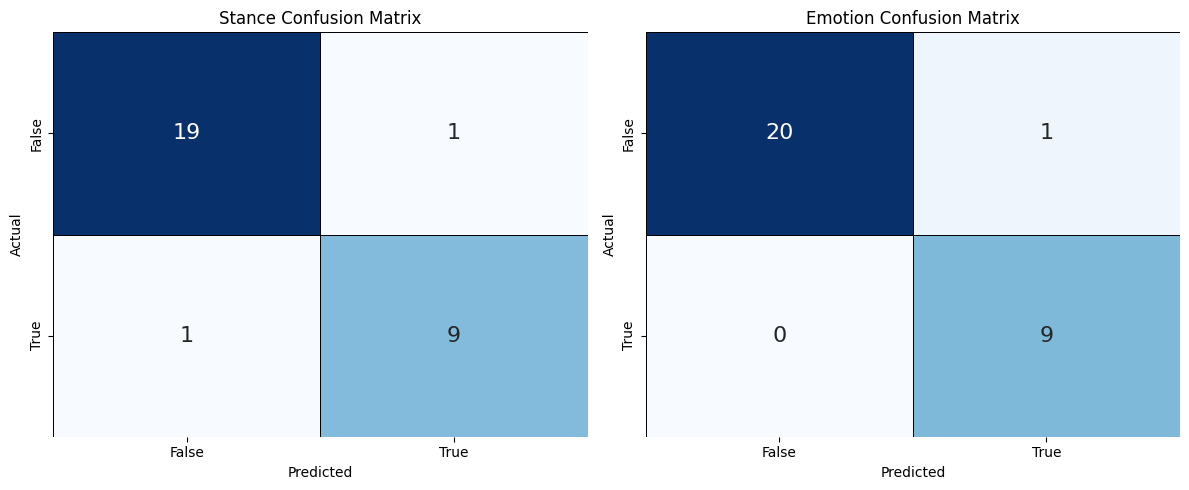

In [ ]:
# Create confusion matrices for both DataFrames
confusion_matrix_stance = pd.crosstab(
    stance_merged_df['assigned'],
    stance_merged_df['pred'],
    rownames=['Actual'],
    colnames=['Predicted']
)

confusion_matrix_emotion = pd.crosstab(
    emotion_merged_df['assigned'],
    emotion_merged_df['pred'],
    rownames=['Actual'],
    colnames=['Predicted']
)

# Set up the matplotlib figure with subplots
plt.figure(figsize=(12, 5))

# Plot the confusion matrix for stance_merged_df
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix_stance, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Stance Confusion Matrix')

# Plot the confusion matrix for emotion_merged_df
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix_emotion, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Emotion Confusion Matrix')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**8.2 Calculate reliability stats**



In [ ]:
def calculate_stats(confusion_matrix):
    # Handle cases where labels might differ
    actual_labels = confusion_matrix.index.tolist()
    predicted_labels = confusion_matrix.columns.tolist()

    # Extract True Positives, False Positives, True Negatives, and False Negatives
    TP = confusion_matrix.loc[actual_labels[1], predicted_labels[1]] if len(actual_labels) > 1 and len(predicted_labels) > 1 else 0
    FP = confusion_matrix.loc[actual_labels[0], predicted_labels[1]] if len(actual_labels) > 1 and len(predicted_labels) > 1 else 0
    TN = confusion_matrix.loc[actual_labels[0], predicted_labels[0]] if len(actual_labels) > 0 and len(predicted_labels) > 0 else 0
    FN = confusion_matrix.loc[actual_labels[1], predicted_labels[0]] if len(actual_labels) > 1 and len(predicted_labels) > 0 else 0

    # Calculate precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # Calculate recall
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, accuracy, f1_score

# Calculate stats for stance confusion matrix
precision_stance, recall_stance, accuracy_stance, f1_stance = calculate_stats(confusion_matrix_stance)
print(f"Stance\n------\nPrecision: {precision_stance:.3f}\nRecall: {recall_stance:.3f}\nAccuracy: {accuracy_stance:.3f}\nF1 Score: {f1_stance:.3f}\n\n")

# Calculate stats for emotion confusion matrix
precision_emotion, recall_emotion, accuracy_emotion, f1_emotion = calculate_stats(confusion_matrix_emotion)
print(f"Emotion\n-------\nPrecision: {precision_emotion:.3f}\nRecall: {recall_emotion:.3f}\nAccuracy: {accuracy_emotion:.3f}\nF1 Score: {f1_emotion:.3f}")

Stance
------
Precision: 0.900
Recall: 0.900
Accuracy: 0.933
F1 Score: 0.900


Emotion
-------
Precision: 0.900
Recall: 1.000
Accuracy: 0.967
F1 Score: 0.947


# **9. What now?**


---



1.   Do the human coders show good agreement for stance and emotion?

2.   Do the AI 'coders' show good agreement for stance and emotion?

2.   How can we get better agreement between humans and AI coders?

3.   What other prompting methods could we try to improve results?







# **Acknowledgements**

This research was funded by the Australian Research Council through the Australian Laureate Fellowship project Determining the Drivers and Dynamics of Partisanship and Polarisation in Online Public Debate.

# **References**

Huilgol, P. (2019) https://medium.com/analytics-vidhya/accuracy-vs-f1-score-6258237beca2, Analytics Vidhya

Krippendorff, K. (n.d.). Computing Krippendorff’s Alpha-Reliability. https://www.asc.upenn.edu/sites/default/files/2021-03/Computing%20Krippendorff%27s%20Alpha-Reliability.pdf